In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import nn
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision as tv
from torchsummary import summary

In [ ]:
import torch.utils
import torch.utils.data


BATCH_SIZE = 256
transforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((224, 224)),
    tv.transforms.ToTensor(),
])
train_dataset = tv.datasets.EMNIST('.', train=True, transform=transforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

100%|██████████| 561753746/561753746 [00:11<00:00, 49545922.04it/s]


Extracting ./EMNIST/raw/gzip.zip to ./EMNIST/raw


In [ ]:
image = train_dataset[0][0].numpy()
print(image.shape)

(3, 224, 224)


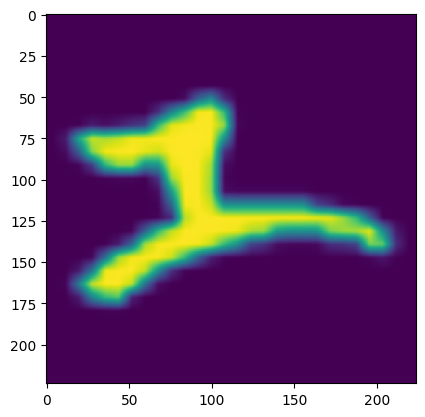

In [ ]:
plt.imshow(train_dataset[2][0][0].squeeze())

In [ ]:
classes = train_dataset.classes
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [ ]:
from collections import Counter

train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]

train_class_counts = Counter(train_labels)
test_class_counts = Counter(test_labels)

print("Обучающий набор данных:")
for class_idx, count in train_class_counts.items():
    print(f"Класс {class_idx}: {count} экземпляров")

print("\nТестовый набор данных:")
for class_idx, count in test_class_counts.items():
    print(f"Класс {class_idx}: {count} экземпляров")

Обучающий набор данных:
Класс 4: 6000 экземпляров
Класс 1: 6000 экземпляров
Класс 6: 6000 экземпляров
Класс 7: 6000 экземпляров
Класс 8: 6000 экземпляров
Класс 0: 6000 экземпляров
Класс 9: 6000 экземпляров
Класс 5: 6000 экземпляров
Класс 3: 6000 экземпляров
Класс 2: 6000 экземпляров

Тестовый набор данных:
Класс 1: 1000 экземпляров
Класс 8: 1000 экземпляров
Класс 6: 1000 экземпляров
Класс 7: 1000 экземпляров
Класс 0: 1000 экземпляров
Класс 3: 1000 экземпляров
Класс 4: 1000 экземпляров
Класс 5: 1000 экземпляров
Класс 2: 1000 экземпляров
Класс 9: 1000 экземпляров


In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()

        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 10 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')

    return train_loss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Мощностей мало, на колабе лимиты по использованию ресурсов. Будем учить предобученные модели в 3 эпохи

### Resnet18

In [ ]:
model = tv.models.resnet18(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
summary(model.to(device), input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# Убираем требование градиента:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features=512, out_features=10)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_resnet18 = train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 1.105. Train acc: 0.074. Train Loss: 2.510
Step 10. time since epoch: 8.447. Train acc: 0.258. Train Loss: 2.139
Step 20. time since epoch: 16.158. Train acc: 0.429. Train Loss: 1.884
Step 30. time since epoch: 24.094. Train acc: 0.543. Train Loss: 1.671
Step 40. time since epoch: 31.255. Train acc: 0.615. Train Loss: 1.502
Step 50. time since epoch: 39.121. Train acc: 0.664. Train Loss: 1.367
Step 60. time since epoch: 46.267. Train acc: 0.699. Train Loss: 1.259
Step 70. time since epoch: 55.432. Train acc: 0.726. Train Loss: 1.170
Step 80. time since epoch: 63.245. Train acc: 0.749. Train Loss: 1.095
Step 90. time since epoch: 70.529. Train acc: 0.766. Train Loss: 1.030
Step 100. time since epoch: 78.481. Train acc: 0.779. Train Loss: 0.976
Step 110. time since epoch: 85.659. Train acc: 0.792. Train Loss: 0.929
Step 120. time since epoch: 93.580. Train acc: 0.803. Train Loss: 0.887
Step 130. time since epoch: 100.971. Train acc: 0.812. Train Loss: 0.848
Step

### DenseNet

In [ ]:
model = tv.models.densenet161(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 153MB/s]


In [ ]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier

Linear(in_features=2208, out_features=1000, bias=True)

In [ ]:
model.classifier = nn.Linear(in_features=2208, out_features=10)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.weight
	 classifier.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_dencenet =train(model, train_iter, test_iter, trainer, 3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Step 0. time since epoch: 2.295. Train acc: 0.102. Train Loss: 2.354
Step 10. time since epoch: 24.966. Train acc: 0.399. Train Loss: 1.974
Step 20. time since epoch: 49.438. Train acc: 0.557. Train Loss: 1.696
Step 30. time since epoch: 74.172. Train acc: 0.642. Train Loss: 1.486
Step 40. time since epoch: 97.471. Train acc: 0.692. Train Loss: 1.327
Step 50. time since epoch: 120.591. Train acc: 0.728. Train Loss: 1.204
Step 60. time since epoch: 144.079. Train acc: 0.754. Train Loss: 1.108
Step 70. time since epoch: 168.383. Train acc: 0.772. Train Loss: 1.031
Step 80. time since epoch: 192.324. Train acc: 0.787. Train Loss: 0.967
Step 90. time since epoch: 215.747. Train acc: 0.799. Train Loss: 0.912
Step 100. time since epoch: 239.099. Train acc: 0.809. Train Loss: 0.865
Step 110. time since epoch: 262.319. Train acc: 0.819. Train Loss: 0.825
Step 120. time since epoch: 285.598. Train acc: 0.826. Train Loss: 0.790
Step 130. time since epoch: 309.020. Train acc: 0.834. Train Loss: 0

### VGG16

In [ ]:
model = tv.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.1MB/s]


In [ ]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [ ]:
model.classifier[-1] = nn.Linear(in_features= model.classifier[-1].in_features, out_features=10)

In [ ]:
print("Params to learn:")
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
lass_vgg16 = train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 3.006. Train acc: 0.090. Train Loss: 2.356
Step 10. time since epoch: 19.804. Train acc: 0.413. Train Loss: 1.845
Step 20. time since epoch: 36.702. Train acc: 0.552. Train Loss: 1.535
Step 30. time since epoch: 53.698. Train acc: 0.618. Train Loss: 1.338
Step 40. time since epoch: 71.268. Train acc: 0.662. Train Loss: 1.200
Step 50. time since epoch: 88.917. Train acc: 0.691. Train Loss: 1.100
Step 60. time since epoch: 107.219. Train acc: 0.713. Train Loss: 1.025
Step 70. time since epoch: 125.734. Train acc: 0.731. Train Loss: 0.964
Step 80. time since epoch: 144.708. Train acc: 0.744. Train Loss: 0.915
Step 90. time since epoch: 163.147. Train acc: 0.755. Train Loss: 0.872
Step 100. time since epoch: 181.510. Train acc: 0.764. Train Loss: 0.838
Step 110. time since epoch: 200.010. Train acc: 0.772. Train Loss: 0.809
Step 120. time since epoch: 218.532. Train acc: 0.779. Train Loss: 0.781
Step 130. time since epoch: 237.282. Train acc: 0.786. Train Loss: 0.

### Inception v3

In [ ]:
BATCH_SIZE = 256
transoforms = tv.transforms.Compose([
    tv.transforms.Grayscale(3),
    tv.transforms.Resize((299, 299)),
    tv.transforms.ToTensor()
])

train_dataset = tv.datasets.EMNIST('.', train=True, transform=transoforms, download=True, split='mnist')
test_dataset = tv.datasets.EMNIST('.', train=False, transform=transoforms, download=True, split='mnist')
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
image = train_dataset[0][0].numpy()
print(image.shape)

(3, 299, 299)


In [ ]:
model = tv.models.inception_v3(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 176MB/s]


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0, 0
    net.eval()
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        y_hat = net(X)
        acc_sum += (y_hat.argmax(axis=1) == y).sum()
        n += y.shape[0]
        return 0
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    train_loss = []
    net.to(device)
    loss = nn.CrossEntropyLoss(reduction='sum')
    #net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        net.train()
        for i, (X, y) in enumerate(train_iter):
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat[0], y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat[0].argmax(axis=1) == y).sum().item()
            n += y.shape[0]

            if i % 100 == 0:
              print(f"Step {i}. time since epoch: {time.time() -  start:.3f}. "
                    f"Train acc: {train_acc_sum / n:.3f}. Train Loss: {train_l_sum / n:.3f}")
        test_acc = evaluate_accuracy(test_iter, net.to(device))
        print('-' * 20)
        train_loss.append(train_l_sum / n)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}'
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
    return train_loss

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [ ]:
model.fc = nn.Linear(in_features= 2048, out_features=10)

In [ ]:
print('Params to learn:')
params_to_update = []
for name, param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
trainer = torch.optim.Adam(params_to_update, lr=0.001)

In [ ]:
loss_inception = train(model, train_iter, test_iter, trainer, 3)

Step 0. time since epoch: 2.227. Train acc: 0.121. Train Loss: 2.290
Step 100. time since epoch: 192.322. Train acc: 0.684. Train Loss: 1.200
Step 200. time since epoch: 381.981. Train acc: 0.752. Train Loss: 0.933
--------------------
epoch 1, loss 0.8834, train acc 0.763, test acc 0.000, time 446.0 sec
Step 0. time since epoch: 2.231. Train acc: 0.855. Train Loss: 0.571
Step 100. time since epoch: 195.540. Train acc: 0.843. Train Loss: 0.534
Step 200. time since epoch: 389.065. Train acc: 0.847. Train Loss: 0.512
--------------------
epoch 2, loss 0.5071, train acc 0.848, test acc 0.000, time 454.2 sec
Step 0. time since epoch: 2.236. Train acc: 0.863. Train Loss: 0.492
Step 100. time since epoch: 196.641. Train acc: 0.860. Train Loss: 0.454
Step 200. time since epoch: 389.882. Train acc: 0.862. Train Loss: 0.446
--------------------
epoch 3, loss 0.4454, train acc 0.862, test acc 0.000, time 455.2 sec


In [ ]:
data =[lass_vgg16, loss_inception]
columns = ['loss_vgg16', 'loss_inception']
results =pd.DataFrame(data=data, index=columns)

file_path = '/content/drive/My Drive/result.csv'
results.to_csv(file_path, index=False)

In [ ]:
data = [loss_resnet18]
columns = ['loss_resnet18']
results =pd.DataFrame(data=data, index=columns)

file_path = '/content/drive/My Drive/result_resnet.csv'
results.to_csv(file_path, index=True)

In [ ]:
Loss_models = pd.read_csv('/content/drive/My Drive/result.csv')
Loss_models

,0,1,2
0,0.610116,0.228105,0.162790
1,0.883406,0.507124,0.445431


In [ ]:
loss_resnet18

,Unnamed: 0,0,1,2
0,loss_resnet18,0.615862,0.216015,0.162803


In [ ]:
loss_dencenet

[0.559256498336792, 0.2086423272450765, 0.1562183561007182]

In [ ]:
data = [loss_dencenet, [0.615862,0.216015, 0.162803], [0.610116, 0.228105, 0.162790], [0.883406, 0.507124, 0.445431]]
columns = ['loss_dencenet', 'loss_resnet18', 'loss_vgg16', 'loss_inception']
results =pd.DataFrame(data=data, index=columns)
results

,0,1,2
loss_dencenet,0.559256,0.208642,0.156218
loss_resnet18,0.615862,0.216015,0.162803
loss_vgg16,0.610116,0.228105,0.162790
loss_inception,0.883406,0.507124,0.445431


<ipython-input-44-0442b674d4e4>:2: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-b" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot( df['loss_dencenet'], 'o-b', label='densenet161', linestyle='--')
<ipython-input-44-0442b674d4e4>:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-r" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(df['loss_resnet18'], 'o-r', label='resnet18', linestyle='--')
<ipython-input-44-0442b674d4e4>:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.g" (-> linestyle='-.'). The keyword argument will take precedence.
  plt.plot(df['loss_vgg16'],'o-.g', label='vgg16', linestyle='--')
<ipython-input-44-0442b674d4e4>:5: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-.y" (-> linestyle='-.'). Th

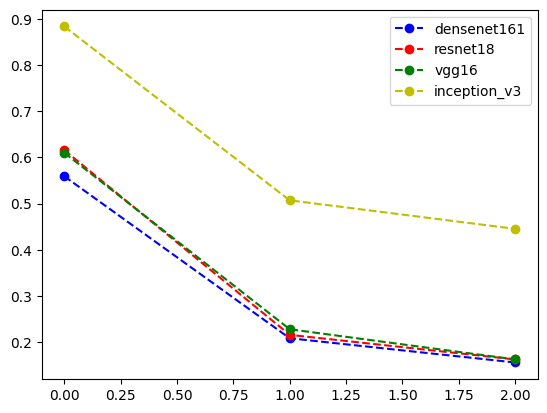

In [ ]:
df=results.astype(float).T
plt.plot( df['loss_dencenet'], 'o-b', label='densenet161', linestyle='--')
plt.plot(df['loss_resnet18'], 'o-r', label='resnet18', linestyle='--')
plt.plot(df['loss_vgg16'],'o-.g', label='vgg16', linestyle='--')
plt.plot(df['loss_inception'],'o-.y', label='inception_v3', linestyle='--')
plt.legend()